# Description SVM

## Libraries

In [1]:
!pip install wikidata

import nltk
import time
import math
import tqdm
import json
import spacy
import joblib
import requests
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from bs4 import BeautifulSoup
from itertools import product
from nltk.corpus import stopwords
from wikidata.client import Client
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Collecting the dataset

In [6]:
# Da sistemare per la consegna
from google.colab import drive, files

drive.mount('/content/gdrive', force_remount=False)

dir_path   =  "/content/gdrive/My Drive/MNLP/HW1/"
train_path = "train.csv"
dev_path   = "valid.csv"

train_df = pd.read_csv(dir_path + train_path, encoding='utf-8')
dev_df = pd.read_csv(dir_path + dev_path, encoding='utf-8')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## TF_IDF computation

### Methods

In [7]:
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

subcat_list = [subcat.lower() for subcat in list(train_df['subcategory'].unique()) if ' ' in subcat]

def tokenize(doc):
    tokens = word_tokenize(doc.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

def tf(doc):
    tf_ = {}
    words = tokenize(doc)
    cnt = Counter(words)
    normalization_factor = len(words)
    for word, occs in cnt.items():
        tf_[word] = occs / normalization_factor

    return tf_

def idf(texts):
    idf_ = {}
    N = len(texts)
    tokenized_docs = [set(tokenize(doc)) for doc in texts]
    all_words = set(word for doc in tokenized_docs for word in doc)

    for word in tqdm.tqdm(all_words):
        doc_cnt = sum(1 for doc in tokenized_docs if word in doc)
        idf_[word] = math.log((1 + N) / (1 + doc_cnt)) + 1
    return idf_

def idf_by_category(df):
    categorical_idf = {}
    grouped = df.groupby('category')['description'].apply(list)

    for cat, docs in grouped.items():
        categorical_idf[cat] = idf(docs)

    return categorical_idf

def tf_idf(tf_, idf_):
    return {word: tf_val * idf_.get(word, 0.0) for word, tf_val in tf_.items()}

def vectorize(tfidf_dict, word_index):
    vec = np.zeros(len(word_index))
    for word, value in tfidf_dict.items():
        if word in word_index:
            vec[word_index[word]] = value
    return vec

### Test TF_IDF

### Classic

In [ ]:
idfs = idf(train_df['description'])
classic_tfidf = []

for doc in tqdm.tqdm(train_df['description']):
    tf_ = tf(doc)
    tfidf = tf_idf(tf_, idfs)
    classic_tfidf.append(tfidf)

print(classic_tfidf)

### Enhanced

In [8]:
idf_cat = idf_by_category(train_df)
enhanced_tfidf = []

for _, row in tqdm.tqdm(train_df.iterrows(), total=len(train_df)):
    doc = row['description']
    cat = row['category']
    enh_tf_ = tf(doc)
    enh_idf_ = idf_cat.get(cat, {})
    enh_tfidf = tf_idf(enh_tf_, enh_idf_)
    enhanced_tfidf.append(enh_tfidf)

print(enhanced_tfidf)

100%|██████████| 6251/6251 [00:01<00:00, 6160.18it/s]

[{'film': 0.6377059899299833, 'mohanan': 2.952637389219215}, {'american': 1.0905176612487724, 'band': 0.9258448260989025, 'california': 1.8229258536941786}, {'mort': 1.6000976804949467, 'phil': 1.5555872162867725, 'comic': 0.7414715378303709}, {'american': 1.6357764918731585, 'band': 1.3887672391483539}, {'building': 0.8207159012127168, 'monmouth': 1.9617746640063602, 'wale': 1.8658806398557666}, {'term': 1.7430879600404903, 'city': 0.8441289932057955, 'center': 1.803861812305142}, {'category': 1.5067911490118666, 'south': 1.2321380768448391, 'pacific': 1.5067911490118666, 'cyclone': 1.5067911490118666}, {'novel': 1.1060837365794816, 'james': 1.7213593000789251, 'patterson': 1.85651433611498}, {'attempt': 1.4054248719848255, 'assassinate': 1.5067911490118666, 'adolf': 1.4054248719848255, 'hitler': 1.4054248719848255}, {'american': 0.41354167073232717, 'film': 0.3863925846054893, 'studio': 0.42749002352717225, 'owned': 0.694890334513114, 'walt': 0.7528139213857088, 'disney': 0.752813921

## Test SVM

## Classic vocabulary

In [ ]:
classic_dict = [tf_idf(tf(doc), idfs) for doc in train_df['description']]

In [ ]:
classic_vocab = sorted(set(word for doc in train_df['description'] for word in doc.split()))
classic_word_index = {word: idx for idx, word in enumerate(classic_vocab)}

val_docs = [tf_idf(tf(doc), idfs) for doc in dev_df['description']]

classic_X = np.array([vectorize(doc_tfidf, classic_word_index) for doc_tfidf in classic_dict])
classic_X_val = np.array([vectorize(doc_tfidf, classic_word_index) for doc_tfidf in val_docs])
classic_y = np.array(train_df['label'])
classic_y_val = np.array(dev_df['label'])

## Enhanced Vocabulary

In [9]:
enh_dict = []
for _, row in train_df.iterrows():
    enh_dict.append(tf_idf(tf(row['description']), idf_cat.get(row['category'], {})))

enhanced_vocab = sorted(set(word for doc in train_df['description'] for word in tokenize(doc)))
enhanced_word_index = {word: idx for idx, word in enumerate(enhanced_vocab)}

val_docs = []
for doc, cat in zip(dev_df['description'], dev_df['category']):
    val_docs.append(tf_idf(tf(doc), idf_cat.get(cat, {})))

enhanced_X = np.array([vectorize(doc_tfidf, enhanced_word_index) for doc_tfidf in enh_dict])
enhanced_X_val = np.array([vectorize(doc_tfidf, enhanced_word_index) for doc_tfidf in val_docs])
enhanced_y = np.array(train_df['label'])
enhanced_y_val = np.array(dev_df['label'])

## Enhanced with 1-hot-encoding

In [11]:
cols_to_encode = ['type', 'subcategory']

encoder = OneHotEncoder(handle_unknown='ignore')
onehotvec_train = encoder.fit_transform(train_df[cols_to_encode]).toarray().astype(float)
onehotvec_valid = encoder.transform(dev_df[cols_to_encode]).toarray().astype(float)

In [12]:
enh_dict = []
for _, row in train_df.iterrows():
    enh_dict.append(tf_idf(tf(row['description']), idf_cat.get(row['category'], {})))

enhanced_vocab = sorted(set(word for doc in train_df['description'] for word in tokenize(doc)))
enhanced_word_index = {word: idx for idx, word in enumerate(enhanced_vocab)}

val_docs = []
for doc, cat in zip(dev_df['description'], dev_df['category']):
    val_docs.append(tf_idf(tf(doc), idf_cat.get(cat, {})))

enhanced_X = np.array([vectorize(doc_tfidf, enhanced_word_index) for doc_tfidf in enh_dict])
enhanced_X_val = np.array([vectorize(doc_tfidf, enhanced_word_index) for doc_tfidf in val_docs])
enhanced_y = np.array(train_df['label'])
enhanced_y_val = np.array(dev_df['label'])

enhanced_X = np.hstack([enhanced_X, onehotvec_train])
enhanced_X_val = np.hstack([enhanced_X_val, onehotvec_valid])

### Class weights computation

In [13]:
weights_dict = {
    "cultural agnostic": 0.2995,
    "cultural representative": 0.2700,
    "cultural exclusive": 0.4305
}

def weights_computation(freq_dict):
    weights = {k: 1/v for k, v in freq_dict.items()}
    norm_factor = sum(weights.values())
    norm_weights = {k: v/norm_factor for k, v in weights.items()}
    return norm_weights

class_weights = weights_computation(freq_dict=weights_dict)
print(f"{class_weights}")

{'cultural agnostic': 0.3565110774234955, 'cultural representative': 0.395463213660507, 'cultural exclusive': 0.24802570891599746}


## Test models

### Enhanced TF-IDF

## With 1-hot-encoding

In [14]:
C_vals = [1, 10]
gamma = 'scale'
kernels = ['linear', 'rbf']

enhanced_best_score = 0
enhanced_best_params = {}
enhanced_best_model = None

for C, kernel in product(C_vals, kernels):
    print(f"Testing: C={C}, gamma={gamma}, kernel={kernel}")

    enhanced_svc = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weights)

    try:
        enhanced_svc.fit(enhanced_X, enhanced_y)

        y_pred = enhanced_svc.predict(enhanced_X_val)
        score = accuracy_score(enhanced_y_val, y_pred)

        print(f"Accuracy: {score:.4f}")
        print(f"F1 macro score: {f1_score(enhanced_y_val, y_pred, average='macro'):.4f}")

        if score > enhanced_best_score:
            enhanced_best_score  = score
            enhanced_best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
            enhanced_best_model  = enhanced_svc

    except Exception as e:
        print(f"ERROR! Params:\tC={C}, gamma={gamma}, kernel={kernel}: {e}")

Testing: C=1, gamma=scale, kernel=linear
Accuracy: 0.6533
F1 macro score: 0.6327
Testing: C=1, gamma=scale, kernel=rbf
Accuracy: 0.6100
F1 macro score: 0.5823
Testing: C=10, gamma=scale, kernel=linear
Accuracy: 0.6900
F1 macro score: 0.6783
Testing: C=10, gamma=scale, kernel=rbf
Accuracy: 0.6700
F1 macro score: 0.6510


In [15]:
print("Best parameters found:", enhanced_best_params)
y_pred = enhanced_best_model.predict(enhanced_X_val)
print(classification_report(enhanced_y_val, y_pred))

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
                         precision    recall  f1-score   support

      cultural agnostic       0.81      0.81      0.81       117
     cultural exclusive       0.56      0.66      0.61        76
cultural representative       0.66      0.58      0.62       107

               accuracy                           0.69       300
              macro avg       0.68      0.68      0.68       300
           weighted avg       0.69      0.69      0.69       300



In [16]:
joblib.dump(enhanced_best_model, dir_path + "DescriptionSVM.pkl")

['/content/gdrive/My Drive/MNLP/HW1/DescriptionSVM.pkl']

---

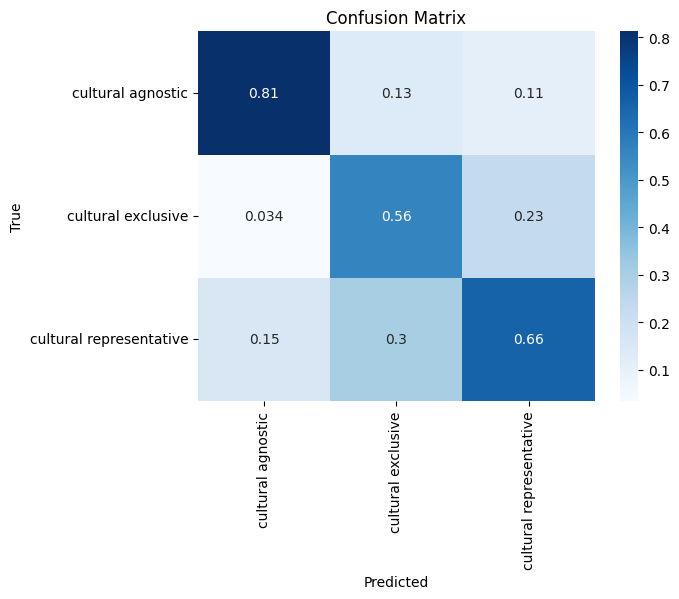

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(enhanced_y_val, y_pred, normalize='pred')
labels = np.unique(enhanced_y_val)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
error_df = dev_df.copy()
error_df['true_label'] = enhanced_y_val
error_df['predicted'] = y_pred
error_df['correct'] = error_df['true_label'] == error_df['predicted']

mistakes = error_df[~error_df['correct']]

mistakes[['name', 'description', 'true_label', 'predicted']].sample(10, random_state=42)

,name,description,true_label,predicted
144,Khalifa,Sufi religious leader and teacher in North and...,cultural representative,cultural agnostic
83,Dato Sri Tahir,Indonesian businessman,cultural representative,cultural exclusive
176,Mike DeCarlo,Comic artist,cultural exclusive,cultural representative
231,rigaudon,cheerful Baroque dance movement in duple meter,cultural exclusive,cultural representative
0,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",cultural representative,cultural exclusive
94,engastration,Cooking technique,cultural agnostic,cultural representative
142,Karl Landsteiner,"Jewish-Austrian biologist, physician and Nobel...",cultural representative,cultural agnostic
220,pope,leader of the worldwide Catholic Church,cultural representative,cultural exclusive
28,art historian,humanist who is engaged in history of art,cultural agnostic,cultural exclusive
152,Les Trois Accords,band,cultural exclusive,cultural representative


In [20]:
mistakes_per_label = mistakes.groupby('true_label')['predicted'].value_counts().unstack(fill_value=0)
print(mistakes_per_label)

predicted                cultural agnostic  cultural exclusive  \
true_label                                                       
cultural agnostic                        0                  12   
cultural exclusive                       4                   0   
cultural representative                 18                  27   

predicted                cultural representative  
true_label                                        
cultural agnostic                             10  
cultural exclusive                            22  
cultural representative                        0  


In [21]:
tokens_errors = [token for doc in mistakes['description'] for token in tokenize(doc)]
common_error_words = Counter(tokens_errors).most_common(50)
print("Most common words in misclassified samples:")
print(common_error_words)

Most common words in misclassified samples:
[('film', 6), ('group', 5), ('american', 4), ('art', 4), ('dance', 4), ('traditional', 4), ('music', 4), ('studio', 4), ('song', 3), ('party', 3), ('particular', 3), ('religious', 3), ('book', 3), ('leader', 3), ('tradition', 3), ('country', 3), ('based', 2), ('body', 2), ('literature', 2), ('type', 2), ('gesture', 2), ('acting', 2), ('festival', 2), ('state', 2), ('museum', 2), ('political', 2), ('profession', 2), ('fabric', 2), ('small', 2), ('title', 2), ('genre', 2), ('official', 2), ('church', 2), ('roman', 2), ('south', 2), ('asia', 2), ('muslim', 2), ('people', 2), ('form', 2), ('object', 2), ('france', 2), ('ancient', 2), ('judaism', 2), ('effect', 2), ('performance', 2), ('prize', 2), ('united', 2), ('religion', 2), ('founded', 2), ('artist', 2)]
